In [3]:
import numpy as np
import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf
import requests
from pathlib import Path
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller

In [2]:
# https://huggingface.co/datasets/edzhu/binance_eth_bnb_btc_usdt_marketdata
def get_sol_usdt_price():
    # URL для получения последней цены для пары SOL/USDT с Binance
    url = "https://api.binance.com/api/v3/ticker/price?symbol=SOLUSDT"

    try:
        # Отправка запроса к API
        response = requests.get(url)
        # Преобразование ответа из формата JSON
        data = response.json()
        # Вывод последней цены
        price = data['price']
        print(f"Последняя цена для SOL/USDT: {price} USDT")
    except Exception as e:
        print("Произошла ошибка при получении данных:", e)

# Вызов функции
get_sol_usdt_price()

Последняя цена для SOL/USDT: 173.18000000 USDT


# Выгрузка данных за месяц( ~~30-ти минутный~~ часовой таймфрейм)

In [2]:
end_time = datetime.now()
start_time = end_time - timedelta(days=90)
start_time_ms = int(start_time.timestamp() * 1000)
end_time_ms = int(end_time.timestamp() * 1000)

In [21]:
end_time = datetime.now()
start_time =  (end_time - timedelta(days=90)).timestamp()
end_time = end_time.timestamp()
diff = end_time - start_time
intervals_count = round(diff / pd.Timedelta('20 days 19:00:00').total_seconds())
intervals_count

4

In [22]:
url = "https://api.binance.com/api/v3/klines"
symbol = "SOLUSDT"
interval = "1h"
# задаю период и перевожу в ms
end_time = datetime.now()
start_time =  end_time - timedelta(days=90) # datetime(2024,3,21,9)#end_time - timedelta(days=90)
end_time_ms = int(end_time.timestamp() * 1000)
td = pd.Timedelta('20 days 19:00:00') # столько можно максимум за один раз вытянуть данных
interval_timeseries = []
for i in range(0, intervals_count):
    start_time = start_time + td
    start_time_ms = int(start_time.timestamp() * 1000)

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time_ms,
        'endTime': end_time_ms
    }

    try:
        response = requests.get(url, params=params)
        klines = response.json()
        # for kline in klines:
        #     open_time = datetime.fromtimestamp(kline[0] / 1000).strftime('%Y-%m-%d %H:%M:%S')
        #     open_price = kline[1]
        #     high_price = kline[2]
        #     low_price = kline[3]
        #     close_price = kline[4]
        #     volume = kline[5]

            # print(f"Дата: {open_time}, Открытие: {open_price}, Максимум: {high_price}, Минимум: {low_price}, Закрытие: {close_price}, Объем: {volume}")
    except Exception as e:
        print(e)
    klines_arr = np.array(klines)
    solusdt_data = pd.DataFrame(klines_arr[:, [0,1,2,3,4,5]],
                            columns = ['open_time','open_price','high_price','low_price','close_price','volume'])
    interval_timeseries.append(solusdt_data)
    

In [24]:
solusdt_data = pd.concat(interval_timeseries)
solusdt_data['open_time'] = solusdt_data['open_time'].astype(np.uint64)
solusdt_data['open_time'] = solusdt_data['open_time'].apply(lambda x: datetime.fromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
print(solusdt_data['open_time'].max(),solusdt_data['open_time'].min())

2024-06-29 17:00:00 2024-04-21 13:00:00


In [25]:
# klines_arr = np.array(klines)
# solusdt_data = pd.DataFrame(klines_arr[:, [0,1,2,3,4,5]],
#                             columns = ['open_time','open_price','high_price','low_price','close_price','volume'])
# solusdt_data['open_time'] = solusdt_data['open_time'].astype(np.uint64)
# solusdt_data['open_time'] = solusdt_data['open_time'].apply(lambda x: datetime.fromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
# print(solusdt_data['open_time'].max(),solusdt_data['open_time'].min())
# записываю данные по цене в файл
solusdt_data.to_csv(f"D:\Репозитории\ADS_MIPT\data\solusdt_data_{str(start_time.date())}_{str(end_time.date())}.csv")

In [13]:
pd.to_datetime(solusdt_data['open_time']).max() - pd.to_datetime(solusdt_data['open_time']).min()

Timedelta('20 days 19:00:00')

# Если за нужный период данные уже скачаны.
Если за нужный период данные уже скачаны, то их нужно прочитать из файла(ов). Они хранятся в нескольких файлах,
потому что Binance api не позволяет получить с помощью одного get-запроса данные за очень большой период.

In [15]:
def align_data():
    data_path_str = 'data' # путь в виде строки
    data_path = Path(data_path_str)
    paths_incutdata = data_path.glob('solusdt*')
    is_first = True
    for path in paths_incutdata:
      if is_first:
        data_concated = pd.read_csv(path)
        is_first = False
      else:
        next_df_iteration = pd.read_csv(path)
        data_concated = pd.concat([data_concated, next_df_iteration])
    return data_concated.drop_duplicates('open_time')

solusdt_data = align_data().drop('Unnamed: 0', axis = 1)

# Распределеине признака

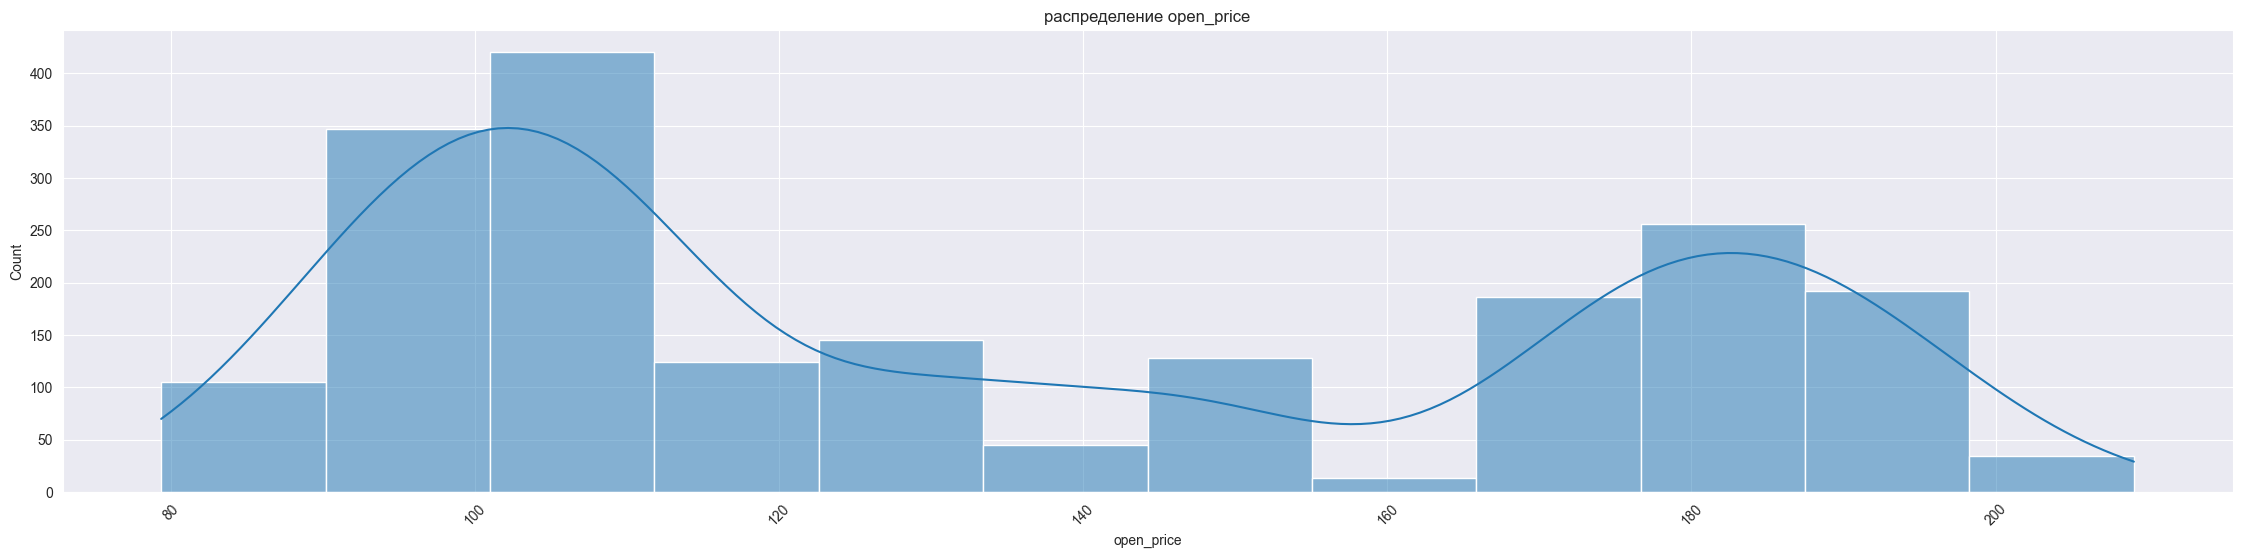

In [16]:
solusdt_data['open_price'] = solusdt_data['open_price'].astype(np.float32)
sns.histplot(data=solusdt_data, x="open_price", kde=True)
plt.xticks(rotation=45)
plt.title("распределение open_price")
plt.show()

# Проверяю ряд на стационарность(переменная: цена в моменте)

https://habr.com/ru/companies/mvideo/articles/769190/

https://bsu.by/upload/page/544153.pdf - определения стационарности и нестацинарности

In [17]:
result = adfuller(solusdt_data['open_price'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print("Вывод:ряд стационарен")
else:
    print("Вывод:ряд нестационарен")
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.428355
p-value: 0.568610
Вывод:ряд нестационарен
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


# ТРЕНД И СЕЗОННОСТЬ

*Тренд* — это долгосрочное изменение в данных, которое может быть восходящим (рост), нисходящим (падение) или
горизонтальным (без изменений). Он представляет собой общее направление движения данных.

**Сезонность** — это периодические колебания в данных, которые повторяются через равные временные интервалы. Сезонность
может быть годовой, месячной, недельной и т. д. Она связана с событиями, которые регулярно влияют на данные.

**Шум (остаток)** — это случайные изменения в данных, которые не могут быть объяснены трендом или сезонностью. Он
представляет собой нерегулярные колебания и вариации в данных.

In [18]:
solusdt_data = solusdt_data.sort_values('open_time')
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=solusdt_data['open_time'],
    y=solusdt_data['open_price'],
    mode='lines',
    line=dict(width=2.5, color='rgb(150, 210, 255)'), #'rgb(150, 210, 255)'
    #stackgroup='one',
    name= 'SOL/USDT')
)

fig.update_layout(
    showlegend=True,
    yaxis=dict(
        type='linear',
        ))#range=[0, 1]

fig.update_traces(textfont_color='rgb(255,255,255)', selector=dict(type='sankey'))
fig.update_layout(title_text="Котировка", font_size=14)
fig.show()

# Автокорреляция
Автокорреляция — это мера корреляции между временным рядом и его лагированными (отстающими) значениями. Это позволяет нам определить зависимость текущих значений от предыдущих.

Частичная автокорреляция — это мера корреляции между временным рядом и его лагированными значениями с учетом корреляции в промежуточных лагах. Она помогает выявить «чистую» зависимость от определенных отстающих значений, исключая влияние промежуточных лагов.

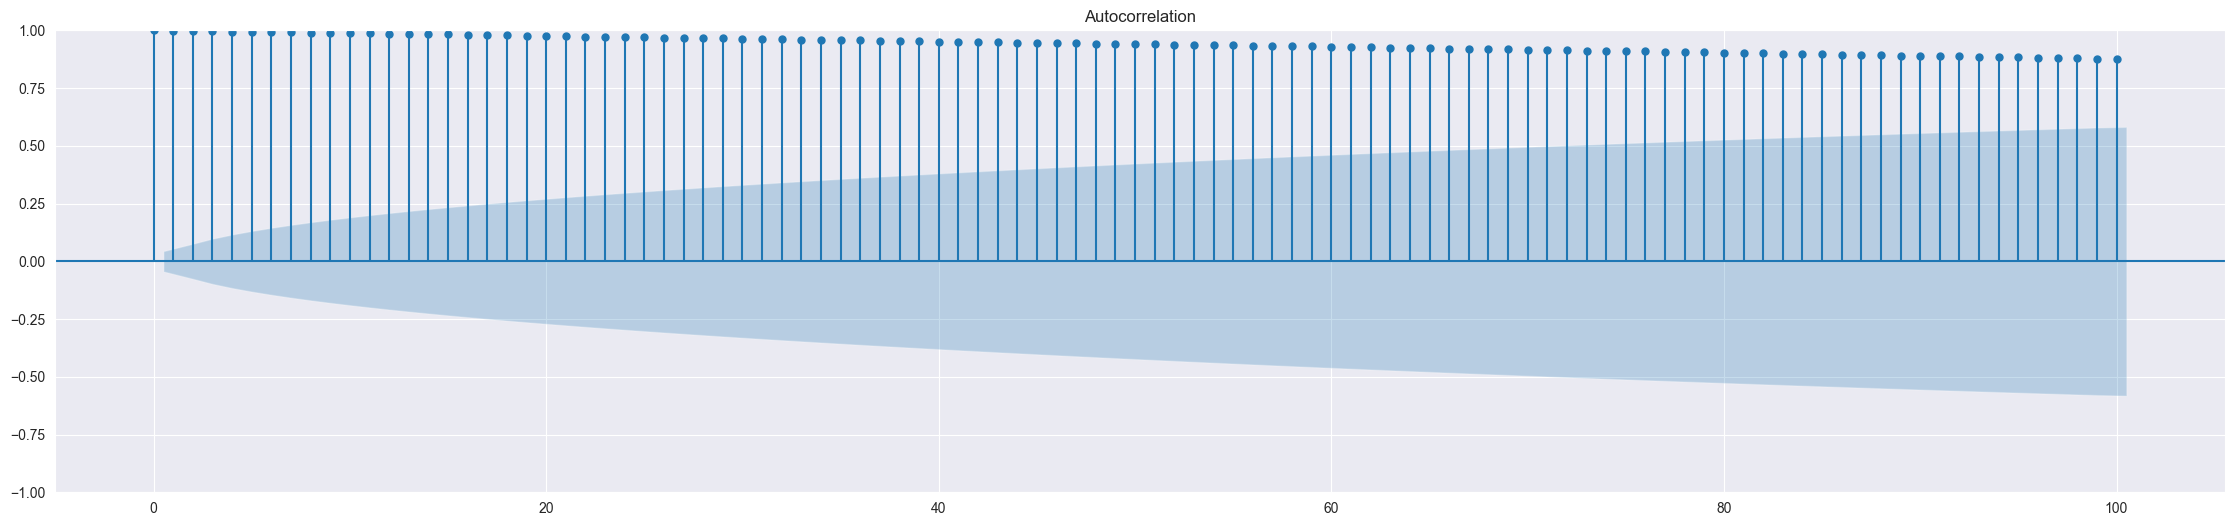

In [19]:
plot_acf(solusdt_data['open_price'], lags=100)
plt.show()

Корреляция становится статистически значимой на 43 лаге.

Автокорреляция постепенно уменьшается по мере увеличения лага, это указывает на автокорреляционный процесс, где более
близкие во времени наблюдения более сильно связаны друг с другом. Это типично для нестационарных временных рядов с трендом.

# точки бифуркации(тест алгоритма Антона, который находит точки бифуркации)

Суть метода в том, что с самой первой точки строится линейная регрессия, так в несколько итераций, пока последняя
предсказанная точка не будет отличаться от реального значения на threshold. Тогда с этой точки начинает строиться
новая линейная регрессия.

![бифуркация](assets/бифуркация.png)

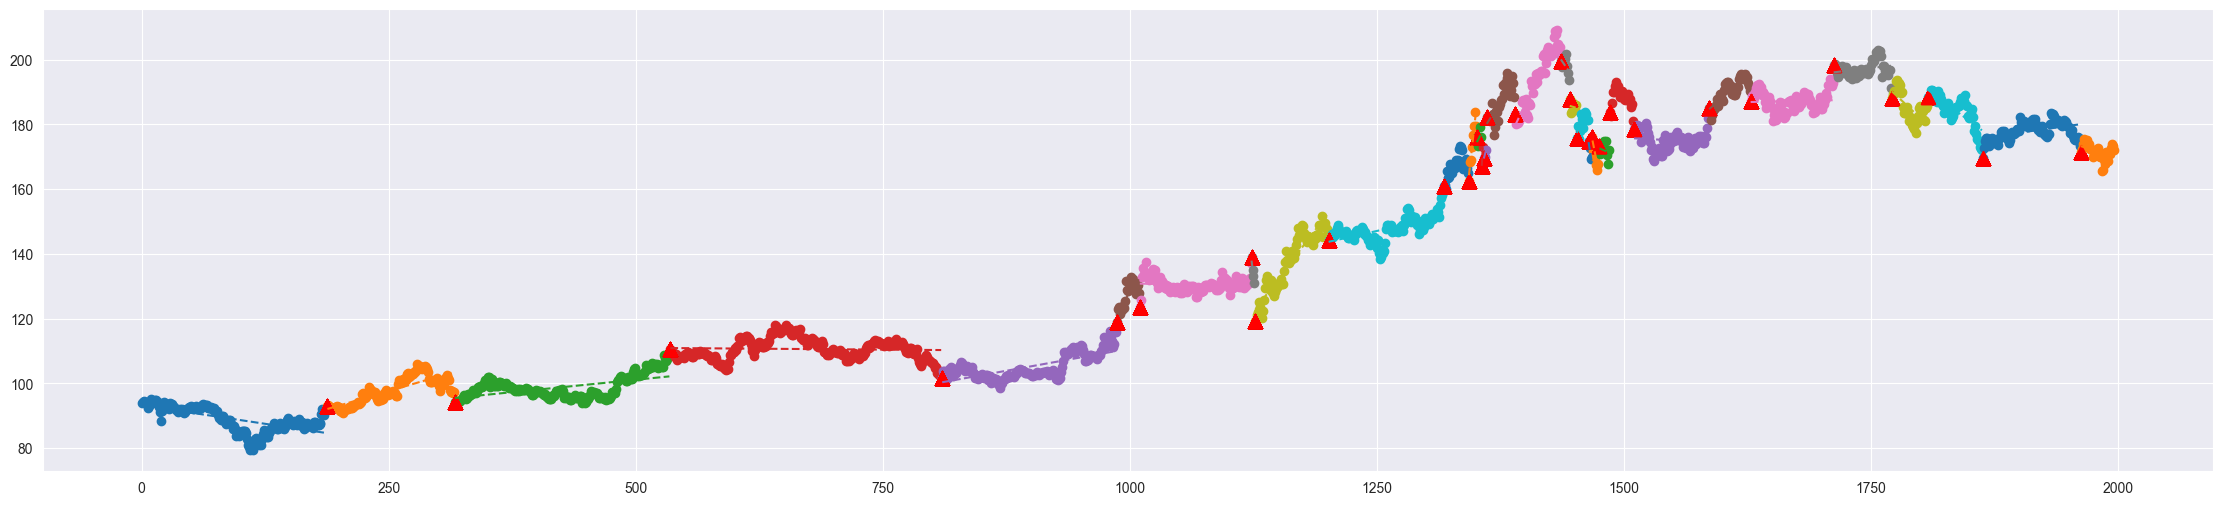

In [20]:
from berak import berak_trend_line
from pylab import rcParams
rcParams['figure.figsize'] = 28,6
warn_index, warn_points, section_param = berak_trend_line(solusdt_data['open_price'])
for k,v in section_param.items():
    #print(v)
    #fig, ax = plt.subplots(1,1, figsize = (12,5))
    plt.scatter(x=v['x'] , y=v['y'])
    x = np.linspace(v['x'][0], v['x'][-1], 10)
    # Построение прямой
    y=v['k']*x+v['b']
    plt.plot(x, y, linestyle='--')
    plt.scatter(x=warn_index , y=warn_points, c ="red", marker='^', s = 100)

# Метод поиска точек бифуркации с помощью линий Боллинджера

По сути этот метод ищет точки, в которых временной ряд меняет свой тренд.

In [21]:
# rolling_mean = pd.Series(solusdt_data['open_price']).rolling(window=10).mean()
# rolling_std = pd.Series(solusdt_data['open_price']).rolling(window=10).std()
#
# threshold = 0.5  # Порог для определения значительного изменения
# significant_changes = (rolling_mean.diff().abs() > threshold)
#
# plt.figure(figsize=(10, 4), dpi = 150)
# plt.plot(solusdt_data['open_time'], solusdt_data['open_price'], 'b-', label='исходный ряд')
# plt.plot(solusdt_data['open_time'], rolling_mean, 'r-', label='скользящее среднее')
# rolling_mean.loc[~significant_changes] = np.nan
# plt.scatter(solusdt_data['open_time'], rolling_mean, color='red', label='точки бифуркации',
#             zorder=1)
# #plt.plot(solusdt_data['open_time'], rolling_std, 'g-', label='скользящее СКО')
# plt.legend()
#
# plt.xlabel('Время');

**Линии Боллинджера** (*Bollinger Bands*) — это технический индикатор, используемый в анализе финансовых рынков, особенно для анализа цен акций, облигаций, валют и других торгуемых активов. Этот индикатор был разработан Джоном Боллинджером в 1980-х годах.

### Структура Линий Боллинджера
Линии Боллинджера состоят из трёх линий, которые рисуются на графике цен актива:

- **Средняя линия (Middle Band)** — обычно это простое скользящее среднее (SMA) цены закрытия актива за определённый период времени (например, за 20 дней).
- **Верхняя линия (Upper Band)** — рассчитывается как средняя линия плюс умноженное на два стандартное отклонение цен за тот же период времени. Стандартное отклонение показывает, насколько широко цены распространяются вокруг среднего значения.
- **Нижняя линия (Lower Band)** — рассчитывается как средняя линия минус умноженное на два стандартное отклонение.

### Применение Линий Боллинджера
Линии Боллинджера помогают определить степень волатильности рынка и могут указывать на потенциальные точки разворота цены или перекупленности/перепроданности актива. Вот некоторые из ключевых аспектов их использования:

- **Волатильность**: Расстояние между верхней и нижней линиями показывает уровень волатильности рынка. Чем шире полосы, тем выше волатильность, и наоборот.
- **Тренды**: Если цены двигаются вдоль одной из линий, это может указывать на сильный тренд. Например, цены, поддерживающиеся верхней линией, могут указывать на восходящий тренд.
- **Потенциальные точки входа и выхода**: Цены, которые достигают верхней или нижней линии, могут сигнализировать о возможных точках для открытия или закрытия позиций. Например, если цена достигает верхней линии, это может быть сигналом к продаже по причине перекупленности, в то время как достижение нижней линии может сигнализировать о перепроданности и возможности покупки.

https://www.youtube.com/watch?v=beQq0mmmxpE&ab_channel=AlexKlimov


In [41]:
window = 20
solusdt_data['rolling_mean'] = solusdt_data['open_price'].rolling(window=window).mean()
solusdt_data['rolling_std'] = solusdt_data['open_price'].rolling(window=window).std()
# верхняя
solusdt_data['bollinger_upper'] = solusdt_data['rolling_mean'] + (solusdt_data['rolling_std'] * 2)
# верхняя
solusdt_data['bollinger_lower'] = solusdt_data['rolling_mean'] - (solusdt_data['rolling_std'] * 2)
# solusdt_data['trend'] = np.where(solusdt_data['open_price'] > solusdt_data['rolling_mean'], 'up', 'down')
#
# solusdt_data['trend_change'] = solusdt_data['trend'].ne(solusdt_data['trend'].shift())
# solusdt_data['start_new_trend'] = solusdt_data['trend_change'] & \
#                                   ((solusdt_data['trend'] != solusdt_data['trend'].shift(-1)) &
#                                    (solusdt_data['trend'] != solusdt_data['trend'].shift(1)))
solusdt_data['trend'] = None
def find_trend_points(data):
    def find_point(row):
        # достигает ли цена окрестности плюс-минус 0.5 std от любой линии Боллинджера
        if (row['rolling_mean'] + 1.5 * row['rolling_std'] <= row['open_price']):
            # print((row['bollinger_upper'] - 0.5 * row['rolling_std'],row['open_price'],
            #        row['open_price'],row['bollinger_upper'] + 0.5* row['rolling_std']))
            return 'up'
        elif (row['bollinger_lower'] + 0.5 * row['rolling_std'] >= row['open_price']):
            return 'down'
        else:
            np.nan
    # price = data.loc['open_price']
    # upper = data.loc['bollinger_upper']
    # lower = data.loc['bollinger_lower']
    # rolling_std = data.loc['rolling_std']
    data['trend_point'] = data.apply(find_point, axis = 1)
    data['temp_col'] = data['trend_point'].isna()
    data = data.reset_index(drop=True)
    valid_indices = data.index[~data['temp_col']].tolist()
    #print(valid_indices)
    def find_actual_trendpoint(row):

        current_index = row.name
        if current_index in valid_indices:

            previous_valid_indices = [indx for indx in valid_indices if indx < current_index]
            if previous_valid_indices:
                previous_index = previous_valid_indices[-1]
                #print(previous_index,current_index)
            # чекаю предыдущую промаркированную точку
                if data.loc[previous_index, 'trend_point'] == row['trend_point']:
                    return np.nan
                else:
                    return row['trend_point']
    data['true_trendpoint'] = data.apply(find_actual_trendpoint, axis = 1)
    return data
solusdt_data = find_trend_points(solusdt_data)

In [51]:
solusdt_data['up_trend_point'] = solusdt_data['true_trendpoint'].apply(lambda x: True if x == 'up' else False)
solusdt_data['down_trend_point'] = solusdt_data['true_trendpoint'].apply(lambda x: True if x == 'down' else False)

In [52]:
solusdt_data.loc[solusdt_data['up_trend_point'],'up_trend_point_value'] = solusdt_data.loc[solusdt_data['up_trend_point'],'open_price']
solusdt_data.loc[solusdt_data['down_trend_point'],'down_trend_point_value'] = solusdt_data.loc[solusdt_data['down_trend_point'],'open_price']


In [59]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import ruptures as rpt
# rolling_mean = solusdt_data['open_price'].rolling(window=window).mean()
# rolling_std = pd.Series(solusdt_data['open_price']).rolling(window=window).std()

# threshold = solusdt_data['rolling_mean'].diff().abs().quantile(0.95)
# significant_changes = (solusdt_data['rolling_mean'].diff().abs() > threshold)

trace0 = go.Scatter(
    x=solusdt_data['open_time'],
    y=solusdt_data['open_price'],
    mode='lines',
    name='Исходный ряд'
)

trace1 = go.Scatter(
    x=solusdt_data['open_time'],
    y=solusdt_data['rolling_mean'],
    mode='lines',
    name='Скользящее среднее'
)
# solusdt_data['trend_points'] = np.nan
# solusdt_data.loc[solusdt_data['start_new_trend'],'trend_points'] = solusdt_data.loc[solusdt_data['start_new_trend'],'rolling_mean']
# trace2 = go.Scatter(
#     x=solusdt_data['open_time'],
#     y=solusdt_data['trend_points'],
#     mode='markers',
#     name='Точки бифуркации',
#     marker=dict(color='red')
# )
trace2 = go.Scatter(
    x=solusdt_data['open_time'],
    y=solusdt_data['up_trend_point_value'],
    mode='markers',
    marker=dict(color='green', size=10),
    name='Начало восходящего тренда'
)
trace3 = go.Scatter(
    x=solusdt_data['open_time'],
    y=solusdt_data['down_trend_point_value'],
    mode='markers',
    marker=dict(color='red', size=10),
    name='Начало нисходящего тренда'
)

trace4 = go.Scatter(
    x=solusdt_data['open_time'],
    y=solusdt_data['bollinger_upper'],
    mode='lines',
    name='верхняя граница Боллинджера',
    marker=dict(color='yellow')
)
trace5 = go.Scatter(
    x=solusdt_data['open_time'],
    y=solusdt_data['bollinger_lower'],
    mode='lines',
    name='нижняя граница Боллинджера',
    marker=dict(color='yellow')
)
fig = go.Figure(data=[trace0, trace1, trace2, trace3,trace4, trace5])

fig.update_layout(
    title='Поиск точек бифуркации с использованием скользящего среднего',
    xaxis_title='Время',
    yaxis_title='Цена открытия'
)

# Отображение графика
fig.show()

При этом всегда есть риск получить "ложную точку пробоя"(когда из-за волатильности график касается линии, а потом
происходит резкий отскок и тренд не меняется).

# PELT

min_size: Минимальное количество точек между двумя изменениями.
jump: Шаг по времени, через который проверяются возможные точки разрыва. Увеличение этого параметра может сократить время вычисления за счет небольшой потери точности.
pen: Параметр штрафа, который контролирует число обнаруженных точек изменения. Больший штраф ведет к меньшему числу обнаруженных изменений.

https://pro.arcgis.com/ru/pro-app/latest/tool-reference/space-time-pattern-mining/how-change-point-detection-works.htm#

In [191]:
solusdt_data.shape[0] / 10

199.7

In [ ]:
model = "l1"
algo = rpt.Pelt(model=model, min_size=24, jump=1)
algo.fit(solusdt_data['open_price'].values)

result = algo.predict(pen=solusdt_data.shape[0] / 5)
result = np.array(result) - 1

In [193]:
solusdt_data['trend_points'] = np.nan
solusdt_data.iloc[result, -1] = solusdt_data.iloc[result, 2]

In [194]:
trace0 = go.Scatter(
    x=solusdt_data['open_time'],
    y=solusdt_data['open_price'],
    mode='lines',
    name='SOL/USDT price'
)

trace1 = go.Scatter(
    x=solusdt_data['open_time'],
    y=solusdt_data['rolling_mean'],
    mode='lines',
    name='Скользящее среднее'
)

trace2 = go.Scatter(
    x=solusdt_data['open_time'],
    y=solusdt_data['trend_points'],
    mode='markers',
    name='Точки изменения',
    marker=dict(color='red')
)

fig = go.Figure(data=[trace0, trace1, trace2])

fig.update_layout(
    title='Применение алгоритма PELT',
    xaxis_title='Время',
    yaxis_title='Цена открытия'
)

# Отображение графика
fig.show()